# Toy Stretch Reflex (Spindle + Alpha Motoneuron) — Starter Notebook

> Goal: implement a simple, biologically grounded stretch reflex block that we can later embed in MuJoCo.

## Overview

This notebook implements a **toy stretch reflex** consisting of:
1. **Muscle spindle (Ia) afferent** — simplified rate model driven by muscle length and velocity.  
2. **Golgi tendon organ (Ib) afferent** — simplified rate model driven by tendon/muscle force (optional in first pass).  
3. **Alpha motoneuron (α-MN)** — rate-coded unit integrating afferent inputs to produce muscle activation.  
4. **Hill-type muscle (lumped)** — converts activation to force, with simple force–length–velocity effects.

We simulate a **step stretch** in muscle length and show how the reflex increases activation and force to oppose it.
Later, we can couple this block to a **single-DOF joint** in MuJoCo.

## References (for orientation only)

- Matthews, P. B. C. (1991). The human stretch reflex and the motor cortex. *Trends in Neurosciences*, 14(3), 87–91.  
- Mileusnic, M. P., Brown, I. E., Lan, N., & Loeb, G. E. (2006). Mathematical models of proprioceptors. I. Control and transduction in the muscle spindle. *Journal of Neurophysiology*, 96(4), 1772–1788.  
- Prochazka, A. & Gorassini, M. (1998). Models of ensemble firing of muscle spindle afferents during locomotion. *J Physiol*.  
- Zajac, F. E. (1989). Muscle and tendon: properties, models, scaling, and application. *CRC Crit Rev Biomed Eng*, 17(4), 359–411.

## Model Sketch (simplified)

**Spindle primary (Ia) rate**
- Ia = Ia0 + kL * (L - L0) + kV * max(0, dL/dt)  
  Captures static length sensitivity and dynamic (velocity) sensitivity.

**Golgi tendon organ (Ib) rate (optional first pass)**
- Ib = Ib0 + kF * Fm

**Alpha motoneuron (rate unit)**
- tau_mn * da_mn/dt = -a_mn + ReLU(w_Ia * Ia - w_Ib * Ib + bias)  
- Output activation u = sigmoid(a_mn) in [0, 1].

**Muscle (lumped Hill-type)**
- Activation dynamics: tau_act * dA/dt = -A + u  
- Force: Fm = Fmax * A * fL(L) * fV(dL/dt)  
  - fL(L) = exp(-((L - Lopt)/wL)^2)  
  - fV(dL/dt) = 1 / (1 + cV * dL/dt)  (clipped to stay positive)

For a toy **stretch** test, we impose a length trajectory L(t) with a smooth step at t = t_step.

## Parameters

- Spindle: Ia0, kL, kV  
- Golgi: Ib0, kF (set kF=0 to ignore Ib initially)  
- α-MN: tau_mn, w_Ia, w_Ib, bias  
- Activation: tau_act  
- Muscle: Fmax, Lopt, wL, cV  
- Length trajectory: baseline L0, step amplitude dL, step time t_step

In [1]:
import os
import numpy as np
from typing import Callable
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7, 4)

In [2]:
from dataclasses import dataclass

@dataclass
class SpindleParams:
    Ia0: float = 50.0
    kL: float  = 800.0
    kV: float  = 60.0

@dataclass
class GolgiParams:
    Ib0: float = 10.0
    kF: float  = 0.00

@dataclass
class MNParams:
    tau_mn: float = 0.02
    w_Ia:  float = 0.004
    w_Ib:  float = 0.000
    bias:  float = 0.0

@dataclass
class MuscleParams:
    tau_act: float = 0.03
    Fmax:   float = 1500.0
    Lopt:   float = 1.0
    wL:     float = 0.25
    cV:     float = 2.0

@dataclass
class StretchProfile:
    L0: float = 1.0
    dL: float = 0.02
    t_step: float = 0.5
    t_end: float = 2.0

In [3]:
def length_trajectory(t: float, prof: StretchProfile):
    # Smooth step in length at t_step using tanh for numerical stability.
    # Returns L(t), dLdt(t).
    k = 60.0  # steepness of transition
    s = 0.5 * (1 + np.tanh(k * (t - prof.t_step)))  # 0->1 smooth step
    L = prof.L0 + prof.dL * s
    dLdt = prof.dL * 0.5 * k * (1 - np.tanh(k * (t - prof.t_step))**2)
    return L, dLdt

In [4]:
def spindle_Ia(L, dLdt, p: SpindleParams): # firing rate of the muscle spindle's Ia afferent
    v_pos = max(0.0, dLdt)
    return p.Ia0 + p.kL*(L - 1.0) + p.kV*v_pos

def golgi_Ib(Fm, p: GolgiParams): # firing rate of the Golgi tendon organ's Ib afferent
    return p.Ib0 + p.kF * max(0.0, Fm)

def relu(x): 
    return x if x > 0 else 0.0

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def fL(L, mp: MuscleParams): # force-length relationship
    return np.exp(-((L - mp.Lopt) / mp.wL)**2)

def fV(dLdt, mp: MuscleParams): # force-velocity relationship
    val = 1.0 / (1.0 + mp.cV * dLdt)
    return max(0.05, val)  # clip to avoid zero/negative

def muscle_force(A, L, dLdt, mp: MuscleParams): # total muscle force based on activation, length, and velocity
    return mp.Fmax * A * fL(L, mp) * fV(dLdt, mp)

In [5]:
def reflex_ode(t, y, sp: SpindleParams, gb: GolgiParams, mn: MNParams, mp: MuscleParams, prof: StretchProfile):
    # system of ODEs for the reflex arc
    a_mn, A = y
    L, dLdt = length_trajectory(t, prof)
    
    Ia = spindle_Ia(L, dLdt, sp)
    Fm = muscle_force(A, L, dLdt, mp)
    Ib = golgi_Ib(Fm, gb)
    
    I = mn.w_Ia * Ia - mn.w_Ib * Ib + mn.bias
    da_mn = (-a_mn + max(0.0, I)) / mn.tau_mn
    
    u = sigmoid(a_mn)
    dA = (-A + u) / mp.tau_act
    
    return [da_mn, dA]

In [6]:
sp = SpindleParams()
gb = GolgiParams(kF=0.01)
mn = MNParams(w_Ia=0.004, w_Ib=0.002, bias=0.0)
mp = MuscleParams()
prof = StretchProfile(dL=0.02, t_step=0.5, t_end=2.0)

y0 = [0.0, 0.05]
t_span = (0.0, prof.t_end)
t_eval = np.linspace(t_span[0], t_span[1], 1501)

sol = solve_ivp(lambda t, y: reflex_ode(t, y, sp, gb, mn, mp, prof),
                t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

t = sol.t
a_mn = sol.y[0]
A = sol.y[1]

L = np.zeros_like(t); dLdt = np.zeros_like(t); Ia = np.zeros_like(t); Fm = np.zeros_like(t)
for i, ti in enumerate(t):
    Li, dLi = length_trajectory(ti, prof)
    L[i] = Li; dLdt[i] = dLi
    Ia[i] = spindle_Ia(Li, dLi, sp)
    Fm[i] = muscle_force(A[i], Li, dLi, mp)

print("Simulation complete.")

Simulation complete.


In [7]:
SAVE_DIR = "../results/"
ORIGINAL_DIR = SAVE_DIR + "original/"
os.makedirs(ORIGINAL_DIR, exist_ok=True)

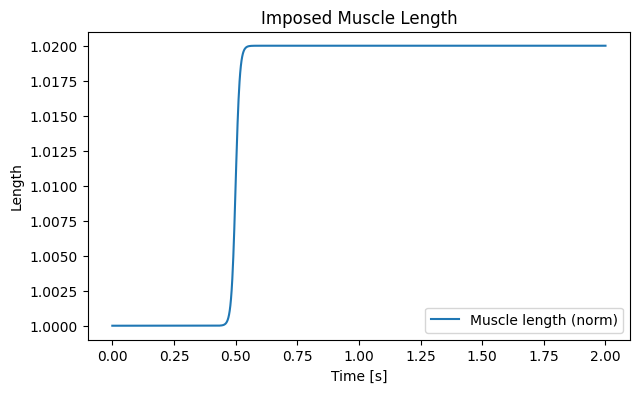

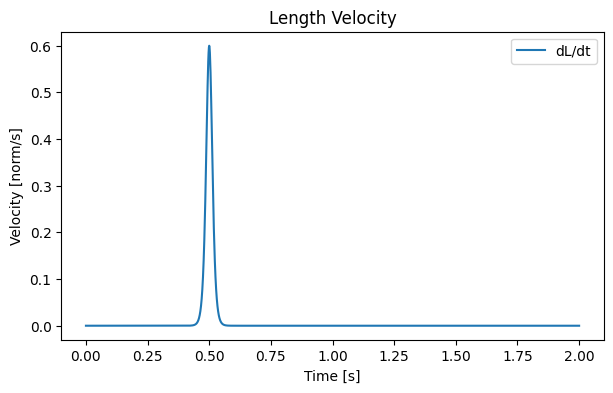

In [ ]:
# Plot results
plt.figure()
plt.plot(t, L, label="Muscle length (norm)")
plt.xlabel("Time [s]"); plt.ylabel("Length")
plt.title("Imposed Muscle Length")
plt.legend()
plt.savefig(os.path.join(ORIGINAL_DIR, "L.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, dLdt, label="dL/dt")
plt.xlabel("Time [s]"); plt.ylabel("Velocity [norm/s]")
plt.title("Length Velocity")
plt.legend()
plt.savefig(os.path.join(ORIGINAL_DIR, "dLdt.png"))
plt.show()
plt.close()

- **Muscle Length Plot:** The muscle length smoothly increases from 1.0 to 1.02 at (t = 0.5) following the expected tanh curve.
- **Length Velocity Plot:** The length velocity exhibits a sharp positive twitch at (t = 0.5), consistent with the derivative of the tanh transition.

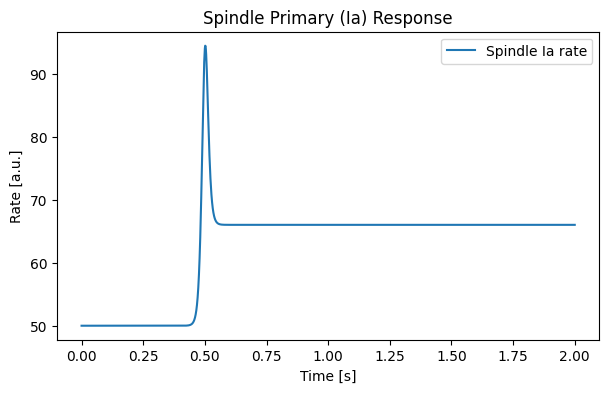

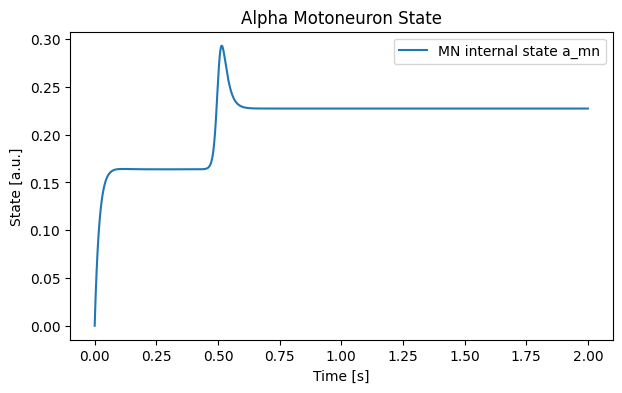

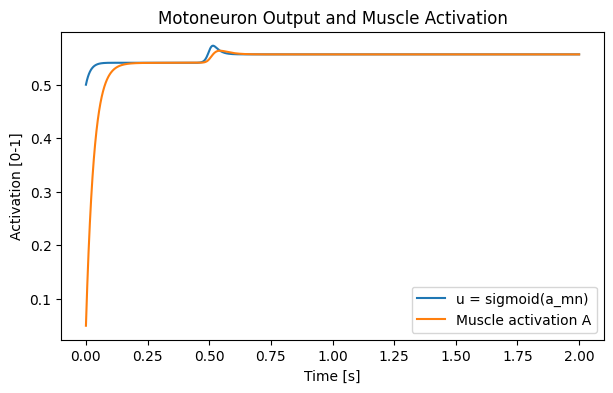

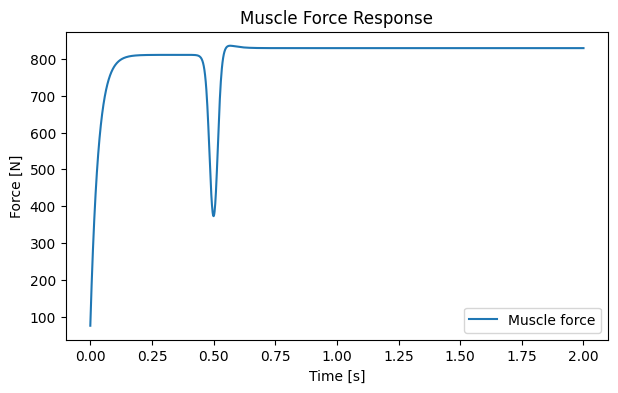

In [9]:
plt.figure()
plt.plot(t, Ia, label="Spindle Ia rate")
plt.xlabel("Time [s]"); plt.ylabel("Rate [a.u.]")
plt.title("Spindle Primary (Ia) Response")
plt.legend()
plt.savefig(os.path.join(ORIGINAL_DIR, "Ia.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, a_mn, label="MN internal state a_mn")
plt.xlabel("Time [s]"); plt.ylabel("State [a.u.]")
plt.title("Alpha Motoneuron State")
plt.legend()
plt.savefig(os.path.join(ORIGINAL_DIR, "a_mn.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, 1/(1+np.exp(-a_mn)), label="u = sigmoid(a_mn)")
plt.plot(t, A, label="Muscle activation A")
plt.xlabel("Time [s]"); plt.ylabel("Activation [0-1]")
plt.title("Motoneuron Output and Muscle Activation")
plt.legend()
plt.savefig(os.path.join(ORIGINAL_DIR, "A.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, Fm, label="Muscle force")
plt.xlabel("Time [s]"); plt.ylabel("Force [N]")
plt.title("Muscle Force Response")
plt.legend()
plt.savefig(os.path.join(ORIGINAL_DIR, "Fm.png"))
plt.show()
plt.close()

- **Spindle Primary (Ia) Response:** The Ia firing rate increases sharply at (t = 0.5), reflecting the muscle's sensitivity to the imposed stretch.
- **Alpha Motoneuron State:** The motoneuron internal state (a_{mn}) rises quickly after (t = 0.5), showing activation in response to the Ia input.
- **Motoneuron Output and Muscle Activation:** The motoneuron output (u) (sigmoid of (a_{mn})) and muscle activation (A) both increase after (t = 0.5), with (A) lagging slightly due to activation dynamics.
- **Muscle Force Response:** Muscle force (F_m) decreases sharply at (t = 0.5) due to the force–velocity relationship during rapid lengthening, then rises again as muscle activation increases.

## Add inhibition

In [10]:
# Parameters for with inhibition
gb_inh = GolgiParams(kF=0.1)
mn_inh = MNParams(w_Ia=0.004, w_Ib=0.01, bias=0.0)

sol_inh = solve_ivp(lambda t, y: reflex_ode(t, y, sp, gb_inh, mn_inh, mp, prof),
                                 t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

t = sol_inh.t
a_mn_inh = sol_inh.y[0]
A_inh = sol_inh.y[1]

L = np.zeros_like(t); dLdt = np.zeros_like(t)
Ia_inh = np.zeros_like(t); Fm_inh = np.zeros_like(t)

for i, ti in enumerate(t):
    Li, dLi = length_trajectory(ti, prof)
    L[i] = Li; dLdt[i] = dLi
    Ia_inh[i] = spindle_Ia(Li, dLi, sp)
    Fm_inh[i] = muscle_force(A_inh[i], Li, dLi, mp)

print("Simulation complete.")

Simulation complete.


In [16]:
INHIBITION_DIR = SAVE_DIR + "inhibition/"
os.makedirs(INHIBITION_DIR, exist_ok=True)

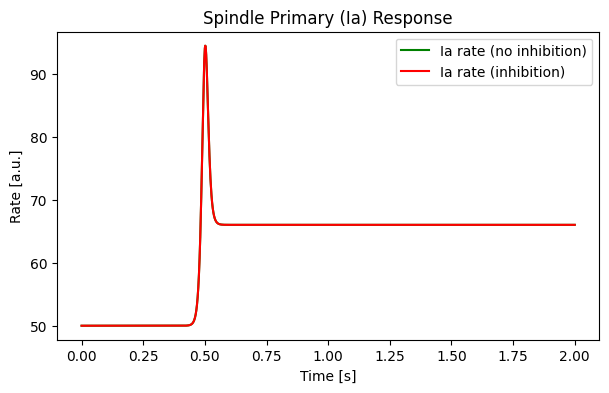

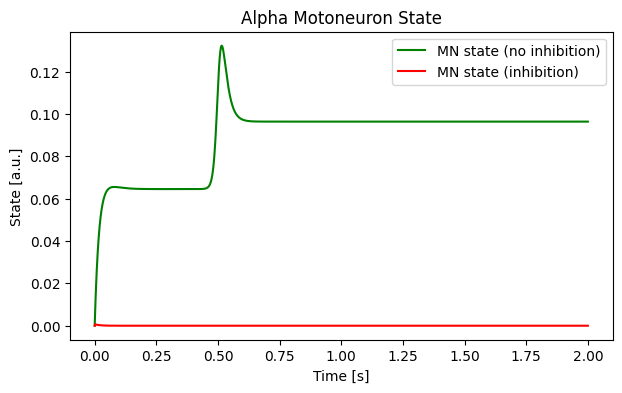

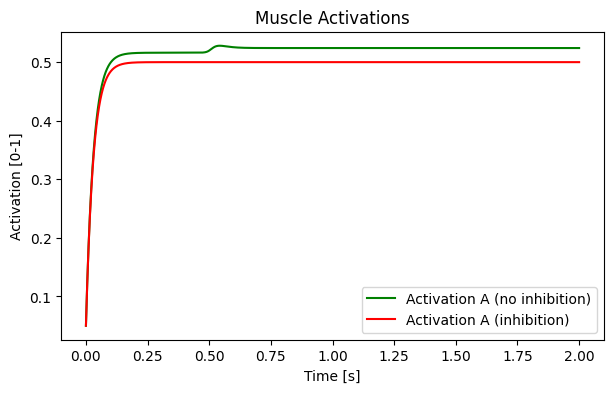

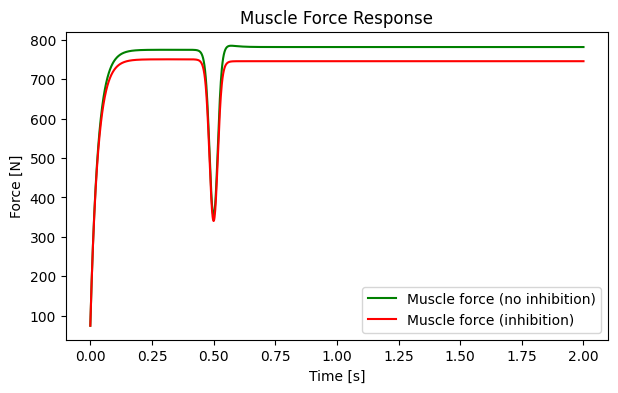

In [17]:
# Plot results
plt.figure()
plt.plot(t, Ia, color="green", label="Ia rate (no inhibition)")
plt.plot(t, Ia_inh, color="red", label="Ia rate (inhibition)")
plt.xlabel("Time [s]"); plt.ylabel("Rate [a.u.]")
plt.title("Spindle Primary (Ia) Response")
plt.legend()
plt.savefig(os.path.join(INHIBITION_DIR, "Ia_inh.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, a_mn, color="green", label="MN state (no inhibition)")
plt.plot(t, a_mn_inh, color="red", label="MN state (inhibition)")
plt.xlabel("Time [s]"); plt.ylabel("State [a.u.]")
plt.title("Alpha Motoneuron State")
plt.legend()
plt.savefig(os.path.join(INHIBITION_DIR, "a_mn_inh.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, A, color="green", label="Activation A (no inhibition)")
plt.plot(t, A_inh, color="red", label="Activation A (inhibition)")
plt.xlabel("Time [s]"); plt.ylabel("Activation [0-1]")
plt.title("Muscle Activations")
plt.legend()
plt.savefig(os.path.join(INHIBITION_DIR, "A_inh.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, Fm, color="green", label="Muscle force (no inhibition)")
plt.plot(t, Fm_inh, color="red", label="Muscle force (inhibition)")
plt.xlabel("Time [s]"); plt.ylabel("Force [N]")
plt.title("Muscle Force Response")
plt.legend()
plt.savefig(os.path.join(INHIBITION_DIR, "Fm_inh.png"))
plt.show()
plt.close()

- **Spindle Primary (Ia) Response:** The Ia rate remains the same with and without inhibition because it depends only on muscle length and velocity, which are unaffected by Ib inhibition.
- **Alpha Motoneuron State:** The (a_{mn}) state is 0 with inhibition because the inhibitory Ib input outweighs the excitatory Ia input, driving the motoneuron state to zero.
- **Motoneuron Output and Muscle Activation:** The motoneuron output (u) and muscle activation (A) are lower with inhibition because the reduced (a_{mn}) directly decreases activation.
- **Muscle Force Response:** Muscle force (F_m) is slightly lower with inhibition due to the reduced muscle activation (A), which directly scales the force.

## Antagonist pair with reciprocal inhibition

In [12]:
# Parameters for antagonist muscle
sp_ant = SpindleParams() 
gb_ant = GolgiParams(kF=0.02)  
mn_ant = MNParams(w_Ia=0.006, w_Ib=0.005, bias=0.0)  
mp_ant = MuscleParams() 

# Extend the state vector
y0 = [0.0, 0.05, 0.0, 0.06]  # [a_mn, A, a_mn_ant, A_ant]

In [13]:
# Modify the ODE function
def reflex_ode_ant(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, prof):
    a_mn, A, a_mn_ant, A_ant = y
    L, dLdt = length_trajectory(t, prof)
    
    # Dynamics
    Ia = spindle_Ia(L, dLdt, sp)
    Fm = muscle_force(A, L, dLdt, mp)
    Ib = golgi_Ib(Fm, gb)
    
    Ia_ant = spindle_Ia(L, dLdt, sp_ant)
    Fm_ant = muscle_force(A_ant, L, dLdt, mp_ant)
    Ib_ant = golgi_Ib(Fm_ant, gb_ant)
    
    # Reciprocal inhibition
    I_agonist = mn.w_Ia * Ia - mn.w_Ib * Ib - 0.002 * Ia_ant  # Reciprocal inhibition from antagonist
    I_antagonist = mn_ant.w_Ia * Ia_ant - mn_ant.w_Ib * Ib_ant - 0.002 * Ia  # Reciprocal inhibition from agonist
    
    # Motoneuron and activation dynamics
    da_mn = (-a_mn + max(0.0, I_agonist)) / mn.tau_mn
    u = sigmoid(a_mn)
    dA = (-A + u) / mp.tau_act
    
    da_mn_ant = (-a_mn_ant + max(0.0, I_antagonist)) / mn_ant.tau_mn
    u_ant = sigmoid(a_mn_ant)
    dA_ant = (-A_ant + u_ant) / mp_ant.tau_act
    
    return [da_mn, dA, da_mn_ant, dA_ant]

In [14]:
sol = solve_ivp(lambda t, y: reflex_ode_ant(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, prof),
                t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

t = sol.t
a_mn = sol.y[0]
A = sol.y[1]
a_mn_ant = sol.y[2]
A_ant = sol.y[3]

L = np.zeros_like(t); dLdt = np.zeros_like(t)
Ia = np.zeros_like(t); Fm = np.zeros_like(t)
Ia_ant = np.zeros_like(t); Fm_ant = np.zeros_like(t)

for i, ti in enumerate(t):
    Li, dLi = length_trajectory(ti, prof)
    L[i] = Li; dLdt[i] = dLi
    Ia[i] = spindle_Ia(Li, dLi, sp)
    Fm[i] = muscle_force(A[i], Li, dLi, mp)
    Ia_ant[i] = spindle_Ia(Li, dLi, sp)
    Fm_ant[i] = muscle_force(A_ant[i], Li, dLi, mp)

print("Simulation complete.")

Simulation complete.


In [18]:
ANTAGONIST_DIR = SAVE_DIR + "antagonist/"
os.makedirs(ANTAGONIST_DIR, exist_ok=True)

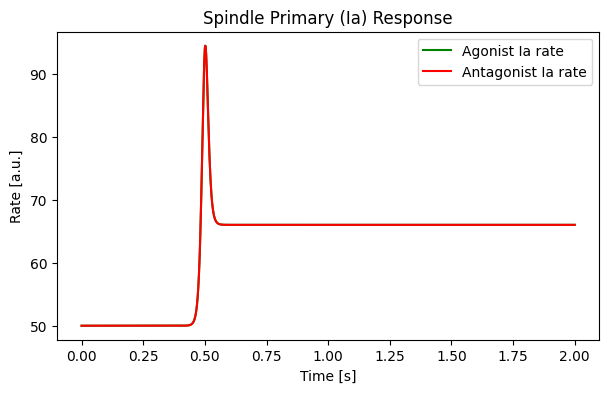

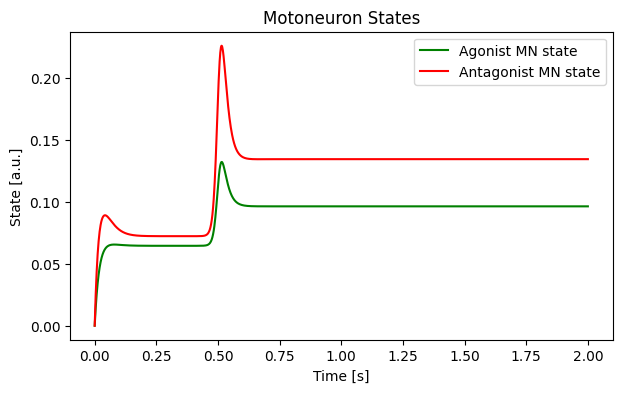

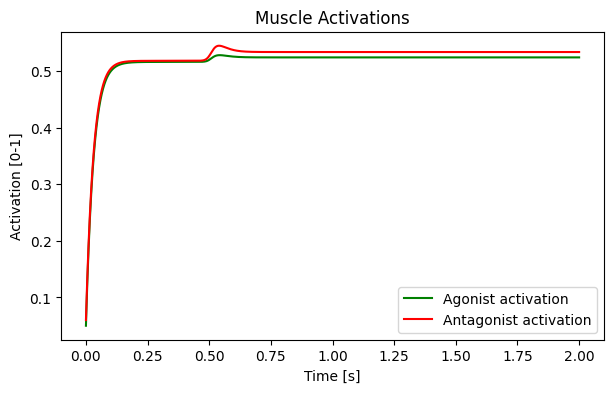

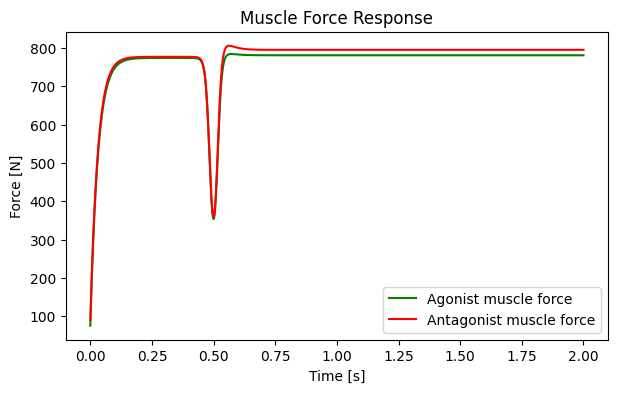

In [19]:
# Plot results
plt.figure()
plt.plot(t, Ia, color="green", label="Agonist Ia rate")
plt.plot(t, Ia_ant, color="red", label="Antagonist Ia rate")
plt.xlabel("Time [s]"); plt.ylabel("Rate [a.u.]")
plt.title("Spindle Primary (Ia) Response")
plt.legend()
plt.savefig(os.path.join(ANTAGONIST_DIR, "Ia_ant.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, a_mn, color="green", label="Agonist MN state")
plt.plot(t, a_mn_ant, color="red", label="Antagonist MN state")
plt.xlabel("Time [s]"); plt.ylabel("State [a.u.]")
plt.title("Motoneuron States")
plt.legend()
plt.savefig(os.path.join(ANTAGONIST_DIR, "a_mn_ant.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, A, color="green", label="Agonist activation")
plt.plot(t, A_ant, color="red", label="Antagonist activation")
plt.xlabel("Time [s]"); plt.ylabel("Activation [0-1]")
plt.title("Muscle Activations")
plt.legend()
plt.savefig(os.path.join(ANTAGONIST_DIR, "A_ant.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(t, Fm, color="green", label="Agonist muscle force")
plt.plot(t, Fm_ant, color="red", label="Antagonist muscle force")
plt.xlabel("Time [s]"); plt.ylabel("Force [N]")
plt.title("Muscle Force Response")
plt.legend()
plt.savefig(os.path.join(ANTAGONIST_DIR, "Fm_ant.png"))
plt.show()
plt.close()

- **Spindle Primary (Ia) Response:** The spindle primary response is identical for both the agonist and antagonist, as it depends only on the shared muscle length and velocity.
- **Alpha Motoneuron State:** The motoneuron state (a_{mn}) over time is similar in shape for both muscles but lower in the agonist due to the values set in kF, w_Ia and w_Ib.
- **Motoneuron Output and Muscle Activation:** Muscle activation (A) follows a similar shape for both muscles but is slightly lower in the agonist, reflecting the reduced motoneuron output.
- **Muscle Force Response:** Muscle force responses (F_m) are similar in shape but slightly lower in the agonist, as force is directly proportional to activation.

## Next Steps

- **Couple to a joint** (MuJoCo): replace imposed length with muscle–tendon kinematics; map forces to joint torques via moment arms.  
- **Fit/validate parameters** to approximate known reflex gains and latencies.